# Data-Original Preprocessing Analysis

This notebook processes the raw Excel files from data-original folder and performs:
1. Combines all ExperimentData into one CSV
2. Removes trials with empty player trajectories in 2P2G and 2P3G
3. Classifies each Excel file based on partnerAgentType into 3 game-types [human, gpt-4.1-mini, mixed]
4. For mixed type, indicates the percentage of human trials
5. Plots collaboration success based on trial data by partnerAgentType
6. Plots collaboration success based on participant data by game-type classification

In [155]:
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ttest_ind
import researchpy
import seaborn as sns
import sys
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.width', None)

print(f"Pandas version: {pd.__version__}")
print(f"Seaborn version: {sns.__version__}")

Pandas version: 2.2.3
Seaborn version: 0.13.2


## Step 0: Helper Functions

In [156]:
def is_empty_trajectory(traj_str):
    """
    Check if trajectory string represents an empty trajectory
    """
    if pd.isna(traj_str) or traj_str == '':
        return True
    try:
        traj = eval(traj_str) if isinstance(traj_str, str) else traj_str
        return len(traj) == 0
    except:
        return True

def has_trajectory_jumps(traj_str, max_jump=1):
    """
    Check if trajectory has jumps greater than max_jump steps
    Returns True if trajectory has jumps > max_jump, False otherwise
    """
    if pd.isna(traj_str) or traj_str == '':
        return False  # Empty trajectory doesn't have jumps

    try:
        # Parse trajectory string
        traj = eval(traj_str) if isinstance(traj_str, str) else traj_str

        # If trajectory is empty or has only one position, no jumps possible
        if len(traj) <= 1:
            return False

        # Check consecutive positions for jumps
        for i in range(1, len(traj)):
            prev_pos = traj[i-1]
            curr_pos = traj[i]

            # Calculate Manhattan distance between consecutive positions
            distance = abs(curr_pos[0] - prev_pos[0]) + abs(curr_pos[1] - prev_pos[1])

            # If distance > max_jump, this is an invalid jump
            if distance > max_jump:
                return True

        return False
    except Exception as e:
        # If we can't parse the trajectory, consider it invalid
        print(f"Warning: Could not parse trajectory: {traj_str[:100]}... Error: {e}")
        return True

def calculate_collaboration_success_rate(df, group_col=None):
    """
    Calculate collaboration success rate
    """
    if group_col:
        return df.groupby(group_col)['collaborationSucceeded'].mean()
    else:
        return df['collaborationSucceeded'].mean()

def classify_game_type(df_file):
    """
    Classify game type based on partnerAgentType values in the file
    Returns: ('human', 'gpt-4.1-mini', 'mixed'), human_percentage
    """
    # Filter for 2P2G and 2P3G trials only
    multiplayer_trials = df_file[df_file['experimentType'].isin(['2P2G', '2P3G'])]

    if len(multiplayer_trials) == 0:
        return 'none', 0  # No multiplayer trials

    partner_types = multiplayer_trials['partnerAgentType'].unique()
    partner_types = [pt for pt in partner_types if pt != 'none']  # Remove 'none'

    if len(partner_types) == 0:
        return 'none', 0
    elif len(partner_types) == 1:
        if partner_types[0] == 'human':
            return 'human', 1.0
        elif partner_types[0] == 'gpt-4.1-mini':
            return 'gpt-4.1-mini', 0.0
    else:
        # Mixed condition
        human_trials = len(multiplayer_trials[multiplayer_trials['partnerAgentType'] == 'human'])
        total_trials = len(multiplayer_trials[multiplayer_trials['partnerAgentType'] != 'none'])
        human_percentage = human_trials / total_trials if total_trials > 0 else 0
        return 'mixed', human_percentage

    return 'unknown', 0

## Step 1: Load and Combine All Excel Files

In [157]:
# Get all Excel files from data-original folder
data_path = './data-original/'
excel_files = glob.glob(os.path.join(data_path, '*.xlsx'))

print(f"Found {len(excel_files)} Excel files to process")

# Initialize lists to store data and file info
all_dataframes = []
file_classifications = []
processing_summary = []

# Process each Excel file
for i, file_path in enumerate(excel_files):
    file_name = os.path.basename(file_path)
    print(f"Processing {i+1}/{len(excel_files)}: {file_name}")

    try:
        # Read Excel file
        df = pd.read_excel(file_path)

        # Add file information
        df['source_file'] = file_name
        df['file_index'] = i

        # Classify game type for this file
        game_type, human_percentage = classify_game_type(df)

        file_info = {
            'file_name': file_name,
            'file_index': i,
            'game_type': game_type,
            'human_percentage': human_percentage,
            'total_trials': len(df),
            'multiplayer_trials': len(df[df['experimentType'].isin(['2P2G', '2P3G'])]),
            'participant_id': df['participantId'].iloc[0] if 'participantId' in df.columns else 'unknown'
        }

        file_classifications.append(file_info)

        # Store original data before filtering
        original_trials = len(df)

        all_dataframes.append(df)

        processing_summary.append({
            'file': file_name,
            'original_trials': original_trials,
            'final_trials': len(df),
            'game_type': game_type,
            'human_percentage': human_percentage
        })

    except Exception as e:
        print(f"Error processing {file_name}: {e}")
        continue

print(f"\nSuccessfully processed {len(all_dataframes)} files")

Found 50 Excel files to process
Processing 1/50: experiment_data_5a5bd24be0cf3d000126849e_room_9922acb2-7db1-47ea-b369-ff389b4e47a5_2025-09-13T18-17-31-453Z.xlsx
Processing 2/50: experiment_data_652c5f38cf13042034313b91_room_b2209a3e-c750-4a3e-a4a4-093f62e7ef08_2025-09-13T18-19-19-226Z.xlsx
Processing 3/50: experiment_data_5b985404a15058000124e508_room_fa684eb1-e4c4-4905-96b7-15cf7b8a3f2d_2025-09-12T16-55-36-623Z.xlsx
Processing 4/50: experiment_data_65b537602cf1fbd4f77c7909_room_8048bfb7-aa2a-4c5f-b0c8-e2b4f0a19dc6_2025-09-13T18-12-18-752Z.xlsx
Processing 5/50: experiment_data_65c10fc4bfa12f9fbcfda656_room_5de6a11a-219d-4804-b614-ef42656f3066_2025-09-13T18-20-41-665Z.xlsx
Processing 6/50: experiment_data_66bce38cdb7f3309e448dc8d_room_fc2813a7-4ebd-43fe-a958-ab321b8830f1_2025-09-12T16-43-58-749Z.xlsx
Processing 7/50: experiment_data_66b5172c8f0bd3b23ce66c22_room_5de6a11a-219d-4804-b614-ef42656f3066_2025-09-13T18-18-27-057Z.xlsx
Processing 8/50: experiment_data_5efaf5d5540ce9953f995009_

## Step 2: Combine All Data and Remove Empty Trajectories

In [158]:
# Combine all dataframes
df_combined = pd.concat(all_dataframes, ignore_index=True, sort=False)
print(f"Combined dataset shape: {df_combined.shape}")
print(f"Columns: {list(df_combined.columns)}")

# Show experiment type distribution
print("\nExperiment type distribution:")
print(df_combined['experimentType'].value_counts())

# Show partner agent type distribution
print("\nPartner agent type distribution:")
print(df_combined['partnerAgentType'].value_counts())

Combined dataset shape: (1738, 43)
Columns: ['trialIndex', 'experimentType', 'partnerAgentType', 'currentPlayer', 'participantId', 'roomId', 'humanPlayerIndex', 'aiPlayerIndex', 'partnerFallbackOccurred', 'partnerFallbackReason', 'partnerFallbackStage', 'partnerFallbackTime', 'partnerFallbackAIType', 'collaborationSucceeded', 'player1GoalReachedStep', 'player2GoalReachedStep', 'newGoalPresented', 'newGoalPosition', 'distanceCondition', 'isNewGoalCloserToPlayer2', 'trialStartTime', 'gptErrorEvents', 'currentPlayerIndex', 'player1Trajectory', 'player2Trajectory', 'player1Actions', 'player2Actions', 'player1RT', 'player2RT', 'player1CurrentGoal', 'player2CurrentGoal', 'player1FirstDetectedGoal', 'player2FirstDetectedGoal', 'player1FinalReachedGoal', 'player2FinalReachedGoal', 'firstDetectedSharedGoal', '_finalized', 'completed', 'endTime', 'newGoalPresentedTime', 'totalSteps', 'source_file', 'file_index']

Experiment type distribution:
experimentType
1P2G    598
2P3G    596
2P2G    395
1P

In [159]:
# Filter for 2P2G and 2P3G trials only for trajectory cleaning
multiplayer_trials = df_combined[df_combined['experimentType'].isin(['2P2G', '2P3G'])].copy()
print(f"Multiplayer trials before filtering: {len(multiplayer_trials)}")

# Remove trials with empty trajectories
if 'player1Trajectory' in multiplayer_trials.columns and 'player2Trajectory' in multiplayer_trials.columns:
    # Check for empty trajectories
    empty_p1_traj = multiplayer_trials['player1Trajectory'].apply(is_empty_trajectory)
    empty_p2_traj = multiplayer_trials['player2Trajectory'].apply(is_empty_trajectory)

    print(f"Trials with empty player1 trajectory: {empty_p1_traj.sum()}")
    print(f"Trials with empty player2 trajectory: {empty_p2_traj.sum()}")

    # Remove trials with empty trajectories
    valid_trials_mask = ~(empty_p1_traj | empty_p2_traj)
    multiplayer_trials_cleaned = multiplayer_trials[valid_trials_mask].copy()

    print(f"Multiplayer trials after removing empty trajectories: {len(multiplayer_trials_cleaned)}")
    print(f"Removed {len(multiplayer_trials) - len(multiplayer_trials_cleaned)} trials with empty trajectories")

    # Update the combined dataframe
    # Keep all 1P trials and cleaned multiplayer trials
    single_player_trials = df_combined[~df_combined['experimentType'].isin(['2P2G', '2P3G'])]
    df_final = pd.concat([single_player_trials, multiplayer_trials_cleaned], ignore_index=True)

else:
    print("Warning: Trajectory columns not found")
    df_final = df_combined.copy()

print(f"\nFinal dataset shape: {df_final.shape}")
print(f"Final experiment type distribution:")
print(df_final['experimentType'].value_counts())

Multiplayer trials before filtering: 991
Trials with empty player1 trajectory: 6
Trials with empty player2 trajectory: 2
Multiplayer trials after removing empty trajectories: 985
Removed 6 trials with empty trajectories

Final dataset shape: (1732, 43)
Final experiment type distribution:
experimentType
1P2G    598
2P3G    591
2P2G    394
1P1G    149
Name: count, dtype: int64


In [160]:
# Additional trajectory cleaning: Remove trials with trajectory jumps > 1 step
print("\n=== TRAJECTORY JUMP DETECTION ===")
print("Checking for trajectory jumps > 1 step in both players...")

# Get the current multiplayer dataset (should be df_final filtered for multiplayer)
current_multiplayer = df_final[df_final['experimentType'].isin(['2P2G', '2P3G'])].copy()
print(f"Current multiplayer trials: {len(current_multiplayer)}")

if 'player1Trajectory' in current_multiplayer.columns and 'player2Trajectory' in current_multiplayer.columns:
    # Check for trajectory jumps > 1 step
    jump_p1_traj = current_multiplayer['player1Trajectory'].apply(has_trajectory_jumps)
    jump_p2_traj = current_multiplayer['player2Trajectory'].apply(has_trajectory_jumps)

    print(f"Trials with player1 trajectory jumps > 1 step: {jump_p1_traj.sum()}")
    print(f"Trials with player2 trajectory jumps > 1 step: {jump_p2_traj.sum()}")
    print(f"Trials with ANY trajectory jumps > 1 step: {(jump_p1_traj | jump_p2_traj).sum()}")

    # Remove trials with trajectory jumps
    valid_jump_mask = ~(jump_p1_traj | jump_p2_traj)
    multiplayer_no_jumps = current_multiplayer[valid_jump_mask].copy()

    print(f"Multiplayer trials after removing trajectory jumps: {len(multiplayer_no_jumps)}")
    print(f"Removed {len(current_multiplayer) - len(multiplayer_no_jumps)} trials with trajectory jumps")

    # Update the final dataframe
    # Keep all 1P trials and cleaned multiplayer trials (no jumps)
    single_player_trials = df_final[~df_final['experimentType'].isin(['2P2G', '2P3G'])]
    df_final = pd.concat([single_player_trials, multiplayer_no_jumps], ignore_index=True)

    print(f"\nFinal dataset shape after jump cleaning: {df_final.shape}")
    print(f"Final experiment type distribution:")
    print(df_final['experimentType'].value_counts())
else:
    print("Warning: Trajectory columns not found")



=== TRAJECTORY JUMP DETECTION ===
Checking for trajectory jumps > 1 step in both players...
Current multiplayer trials: 985
Trials with player1 trajectory jumps > 1 step: 72
Trials with player2 trajectory jumps > 1 step: 80
Trials with ANY trajectory jumps > 1 step: 111
Multiplayer trials after removing trajectory jumps: 874
Removed 111 trials with trajectory jumps

Final dataset shape after jump cleaning: (1621, 43)
Final experiment type distribution:
experimentType
1P2G    598
2P3G    524
2P2G    350
1P1G    149
Name: count, dtype: int64


## Step 3: Game Type Classification Summary

In [161]:
# Create file classification summary
df_file_classification = pd.DataFrame(file_classifications)

print("=== FILE CLASSIFICATION SUMMARY ===")
print(f"Total files: {len(df_file_classification)}")
print("\nGame type distribution:")
game_type_counts = df_file_classification['game_type'].value_counts()
print(game_type_counts)

# Show detailed breakdown
print("\nDetailed file classification:")
summary_cols = ['file_name', 'game_type', 'human_percentage', 'multiplayer_trials', 'participant_id']
print(df_file_classification[summary_cols].to_string(index=False))

# Save file classification
df_file_classification.to_csv('file_classification_summary.csv', index=False)
print("\n✓ Saved file_classification_summary.csv")

=== FILE CLASSIFICATION SUMMARY ===
Total files: 50

Game type distribution:
game_type
human           28
gpt-4.1-mini    11
mixed           11
Name: count, dtype: int64

Detailed file classification:
                                                                                                       file_name    game_type  human_percentage  multiplayer_trials           participant_id
experiment_data_5a5bd24be0cf3d000126849e_room_9922acb2-7db1-47ea-b369-ff389b4e47a5_2025-09-13T18-17-31-453Z.xlsx        human          1.000000                  20 5a5bd24be0cf3d000126849e
experiment_data_652c5f38cf13042034313b91_room_b2209a3e-c750-4a3e-a4a4-093f62e7ef08_2025-09-13T18-19-19-226Z.xlsx gpt-4.1-mini          0.000000                  19 652c5f38cf13042034313b91
experiment_data_5b985404a15058000124e508_room_fa684eb1-e4c4-4905-96b7-15cf7b8a3f2d_2025-09-12T16-55-36-623Z.xlsx        human          1.000000                  20 5b985404a15058000124e508
experiment_data_65b537602cf1fbd4f77c7909_ro

In [162]:
# Detailed analysis of mixed files
mixed_files = df_file_classification[df_file_classification['game_type'] == 'mixed']

if len(mixed_files) > 0:
    print("\n=== MIXED FILES ANALYSIS ===")
    print(f"Number of mixed files: {len(mixed_files)}")
    print("\nHuman percentage distribution in mixed files:")
    for _, row in mixed_files.iterrows():
        print(f"  {row['file_name']}: {row['human_percentage']:.2%} human trials")

    print(f"\nAverage human percentage in mixed files: {mixed_files['human_percentage'].mean():.2%}")
else:
    print("\nNo mixed files found in the dataset")


=== MIXED FILES ANALYSIS ===
Number of mixed files: 11

Human percentage distribution in mixed files:
  experiment_data_65c10fc4bfa12f9fbcfda656_room_5de6a11a-219d-4804-b614-ef42656f3066_2025-09-13T18-20-41-665Z.xlsx: 95.00% human trials
  experiment_data_6527f153bea7b2d7c0d556e4_room_752d4cef-6dc3-4d68-9d9d-0815e9d70bae_2025-09-13T18-32-16-415Z.xlsx: 95.00% human trials
  experiment_data_5f850c99d40bfe1f29078e69_room_49124e6f-79b4-4627-ab53-ba0f80c28c33_2025-09-12T16-48-48-296Z.xlsx: 40.00% human trials
  experiment_data_6731413b949994960fadc176_room_e55b3b94-4195-40a0-b088-223a8c4f1d88_2025-09-12T16-58-28-997Z.xlsx: 30.00% human trials
  experiment_data_6154c1748e0de2c3afdab62c_room_db2021d6-0a33-4478-a117-bf4fbec70cd4_2025-09-12T16-47-47-338Z.xlsx: 95.00% human trials
  experiment_data_670d816961bebcb45b53b929_room_7a5db826-2ab9-4c4c-8578-c93df8f87b1d_2025-09-12T16-57-24-862Z.xlsx: 40.00% human trials
  experiment_data_5aff33bae55f90000139f664_room_61690307-cecf-4eb5-bed9-b1c691b7b

## Step 4: Save Combined Dataset

In [163]:
# Save the combined and cleaned dataset
output_filename = 'combined_experiment_data.csv'
df_final.to_csv(output_filename, index=False)

print(f"✓ Saved combined dataset to {output_filename}")
print(f"Final dataset contains {len(df_final)} trials from {len(excel_files)} participants")

# Show final statistics
print("\n=== FINAL DATASET STATISTICS ===")
print(f"Total trials: {len(df_final)}")
print(f"Unique participants: {df_final['participantId'].nunique()}")
print(f"Experiment types: {df_final['experimentType'].value_counts().to_dict()}")
print(f"Partner agent types: {df_final['partnerAgentType'].value_counts().to_dict()}")

✓ Saved combined dataset to combined_experiment_data.csv
Final dataset contains 1621 trials from 50 participants

=== FINAL DATASET STATISTICS ===
Total trials: 1621
Unique participants: 50
Experiment types: {'1P2G': 598, '2P3G': 524, '2P2G': 350, '1P1G': 149}
Partner agent types: {'none': 747, 'human': 622, 'gpt-4.1-mini': 252}


## Step 5: Plot Collaboration Success by PartnerAgentType (Trial-Level)

Multiplayer trials with collaboration data: 874

=== COLLABORATION SUCCESS BY PARTNER AGENT TYPE (TRIAL-LEVEL) ===
partnerAgentType  total_trials  successful_trials  success_rate  n_participants
    gpt-4.1-mini           252              198.0         0.786              20
           human           622              597.0         0.960              39


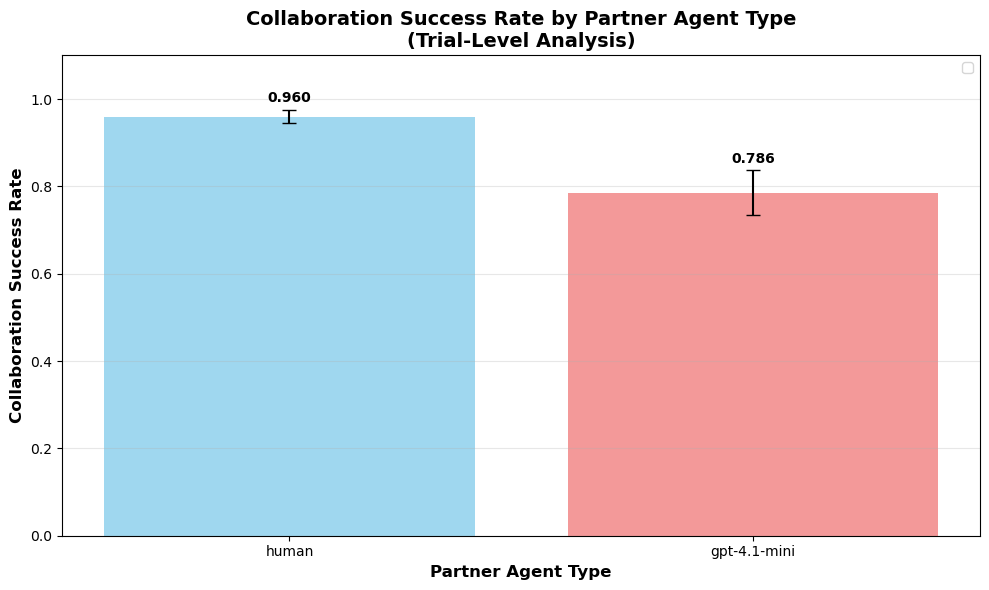


✓ Saved collaboration_success_by_partnerAgentType_trials.csv


In [164]:
# Filter for multiplayer trials with collaboration data
multiplayer_collab = df_final[
    (df_final['experimentType'].isin(['2P2G', '2P3G'])) &
    (df_final['collaborationSucceeded'].notna())
]

print(f"Multiplayer trials with collaboration data: {len(multiplayer_collab)}")

if len(multiplayer_collab) > 0:
    # Calculate collaboration success by partner agent type
    collab_by_agent = multiplayer_collab.groupby('partnerAgentType').agg({
        'collaborationSucceeded': ['count', 'sum', 'mean'],
        'participantId': 'nunique'
    }).round(3)

    collab_by_agent.columns = ['total_trials', 'successful_trials', 'success_rate', 'n_participants']
    collab_by_agent = collab_by_agent.reset_index()

    print("\n=== COLLABORATION SUCCESS BY PARTNER AGENT TYPE (TRIAL-LEVEL) ===")
    print(collab_by_agent.to_string(index=False))

    # Plot collaboration success by partner agent type
    plt.figure(figsize=(10, 6))

    # Calculate confidence intervals for error bars
    success_rates = []
    error_bars = []
    agent_types = []

    for agent_type in multiplayer_collab['partnerAgentType'].unique():
        if agent_type != 'none':  # Skip 'none' trials
            agent_data = multiplayer_collab[multiplayer_collab['partnerAgentType'] == agent_type]
            success_rate = agent_data['collaborationSucceeded'].mean()
            n = len(agent_data)

            # Calculate 95% confidence interval
            se = np.sqrt(success_rate * (1 - success_rate) / n)
            ci = 1.96 * se

            success_rates.append(success_rate)
            error_bars.append(ci)
            agent_types.append(agent_type)

    # Create bar plot
    bars = plt.bar(agent_types, success_rates, yerr=error_bars, capsize=5, alpha=0.8,
                   color=['skyblue', 'lightcoral', 'lightgreen'][:len(agent_types)])

    # Add value labels on bars
    for i, (bar, rate) in enumerate(zip(bars, success_rates)):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + error_bars[i] + 0.01,
                f'{rate:.3f}', ha='center', va='bottom', fontweight='bold')

    plt.xlabel('Partner Agent Type', fontsize=12, fontweight='bold')
    plt.ylabel('Collaboration Success Rate', fontsize=12, fontweight='bold')
    plt.title('Collaboration Success Rate by Partner Agent Type\n(Trial-Level Analysis)',
              fontsize=14, fontweight='bold')
    plt.ylim(0, 1.1)
    plt.grid(True, alpha=0.3, axis='y')

    plt.legend()

    plt.tight_layout()
    plt.savefig('collaboration_success_by_partnerAgentType_trials.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Save the summary data
    collab_by_agent.to_csv('collaboration_success_by_partnerAgentType_trials.csv', index=False)
    print("\n✓ Saved collaboration_success_by_partnerAgentType_trials.csv")

else:
    print("No multiplayer collaboration data found")

## Step 6: Plot Collaboration Success by Game Type (Participant-Level)


=== PARTICIPANT-LEVEL ANALYSIS ===

Participants with multiplayer data: 50

Collaboration success by game type (participant-level):
   game_type  n_participants  mean_success_rate  std_success_rate  total_trials
gpt-4.1-mini              11              0.693             0.278           182
       human              28              0.982             0.034           515
       mixed              11              0.859             0.155           177


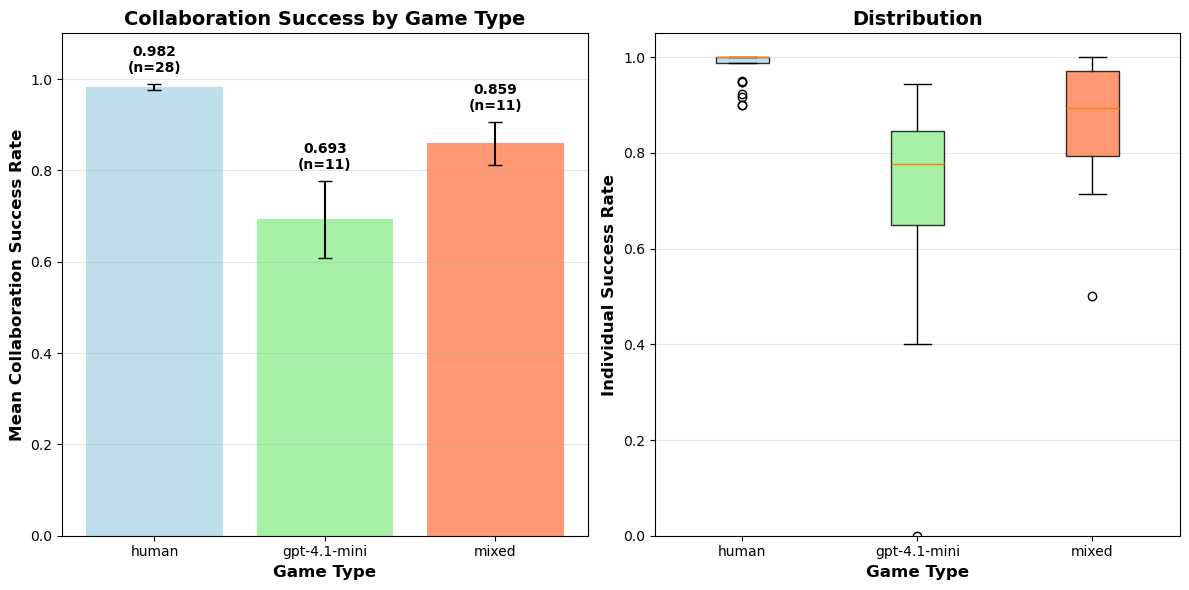


✓ Saved collaboration_success_by_gameType_participants.csv
✓ Saved game_type_summary_statistics.csv


In [173]:
# Create participant-level summary with game type classification
participant_summary = []

for _, file_info in df_file_classification.iterrows():
    if file_info['game_type'] != 'none':  # Skip files with no multiplayer trials
        # Get data for this participant
        participant_data = df_final[
            (df_final['source_file'] == file_info['file_name']) &
            (df_final['experimentType'].isin(['2P2G', '2P3G'])) &
            (df_final['collaborationSucceeded'].notna())
        ]

        if len(participant_data) > 0:
            participant_summary.append({
                'participant_id': file_info['participant_id'],
                'file_name': file_info['file_name'],
                'game_type': file_info['game_type'],
                'human_percentage': file_info['human_percentage'],
                'total_trials': len(participant_data),
                'successful_trials': participant_data['collaborationSucceeded'].sum(),
                'success_rate': participant_data['collaborationSucceeded'].mean(),
                'multiplayer_trials': file_info['multiplayer_trials']
            })

df_participant_summary = pd.DataFrame(participant_summary)

if len(df_participant_summary) > 0:
    print(f"\n=== PARTICIPANT-LEVEL ANALYSIS ===\n")
    print(f"Participants with multiplayer data: {len(df_participant_summary)}")

    # Calculate summary by game type
    game_type_summary = df_participant_summary.groupby('game_type').agg({
        'participant_id': 'count',
        'success_rate': ['mean', 'std', 'count'],
        'total_trials': 'sum'
    }).round(3)

    game_type_summary.columns = ['n_participants', 'mean_success_rate', 'std_success_rate', 'count', 'total_trials']
    game_type_summary = game_type_summary.reset_index()

    print("\nCollaboration success by game type (participant-level):")
    print(game_type_summary[['game_type', 'n_participants', 'mean_success_rate', 'std_success_rate', 'total_trials']].to_string(index=False))

    # Create visualization
    plt.figure(figsize=(12, 6))

    # Plot 1: Average success rate by game type
    plt.subplot(1, 2, 1)

    # Calculate error bars (standard error of the mean)
    game_types = []
    means = []
    errors = []

    for game_type in df_participant_summary['game_type'].unique():
        type_data = df_participant_summary[df_participant_summary['game_type'] == game_type]
        game_types.append(game_type)
        means.append(type_data['success_rate'].mean())
        errors.append(type_data['success_rate'].std() / np.sqrt(len(type_data)))

    bars = plt.bar(game_types, means, yerr=errors, capsize=5, alpha=0.8,
                   color=['lightblue', 'lightgreen', 'coral'][:len(game_types)])

    # Add value labels and sample sizes
    for i, (bar, mean, game_type) in enumerate(zip(bars, means, game_types)):
        n_participants = len(df_participant_summary[df_participant_summary['game_type'] == game_type])
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + errors[i] + 0.02,
                f'{mean:.3f}\n(n={n_participants})', ha='center', va='bottom', fontweight='bold')

    plt.xlabel('Game Type', fontsize=12, fontweight='bold')
    plt.ylabel('Mean Collaboration Success Rate', fontsize=12, fontweight='bold')
    plt.title('Collaboration Success by Game Type', fontsize=14, fontweight='bold')
    plt.ylim(0, 1.1)
    plt.grid(True, alpha=0.3, axis='y')

    # Plot 2: Distribution of individual success rates
    plt.subplot(1, 2, 2)

    # Create box plot - remove capsize parameter which is not valid for boxplot
    if len(df_participant_summary['game_type'].unique()) <= 3:
        # Box plot for better visibility with few categories
        box_data = [df_participant_summary[df_participant_summary['game_type'] == gt]['success_rate'].values
                   for gt in df_participant_summary['game_type'].unique()]

        bp = plt.boxplot(box_data, labels=df_participant_summary['game_type'].unique(),
                        patch_artist=True)  # Removed capsize parameter

        # Color the boxes
        colors = ['lightblue', 'lightgreen', 'coral']
        for patch, color in zip(bp['boxes'], colors[:len(bp['boxes'])]):
            patch.set_facecolor(color)
            patch.set_alpha(0.8)

    plt.xlabel('Game Type', fontsize=12, fontweight='bold')
    plt.ylabel('Individual Success Rate', fontsize=12, fontweight='bold')
    plt.title('Distribution', fontsize=14, fontweight='bold')
    plt.ylim(0, 1.05)
    plt.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.savefig('collaboration_success_by_gameType_participants.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Save participant-level data
    df_participant_summary.to_csv('collaboration_success_by_gameType_participants.csv', index=False)
    game_type_summary.to_csv('game_type_summary_statistics.csv', index=False)

    print("\n✓ Saved collaboration_success_by_gameType_participants.csv")
    print("✓ Saved game_type_summary_statistics.csv")

else:
    print("No participant-level data available")

## Step 7: Statistical Analysis

In [166]:
if len(df_participant_summary) > 0:
    print("\n=== STATISTICAL ANALYSIS ===")

    # Overall summary statistics
    print("\nOverall collaboration success statistics:")
    overall_stats = researchpy.summarize(df_participant_summary['success_rate'])
    print(overall_stats)

    # Compare game types if we have enough data
    game_type_counts = df_participant_summary['game_type'].value_counts()
    print(f"\nGame type distribution: {dict(game_type_counts)}")

    # Statistical tests between game types
    game_types = df_participant_summary['game_type'].unique()

    if len(game_types) >= 2:
        print("\nPairwise comparisons between game types:")

        for i in range(len(game_types)):
            for j in range(i+1, len(game_types)):
                type1, type2 = game_types[i], game_types[j]

                data1 = df_participant_summary[df_participant_summary['game_type'] == type1]['success_rate']
                data2 = df_participant_summary[df_participant_summary['game_type'] == type2]['success_rate']

                if len(data1) >= 3 and len(data2) >= 3:  # Need at least 3 observations each
                    try:
                        desc_stats, test_results = researchpy.ttest(data1, data2)
                        print(f"\n{type1} vs {type2}:")
                        print(desc_stats)
                        print(test_results)
                    except Exception as e:
                        print(f"\nCould not perform t-test between {type1} and {type2}: {e}")

                        # Manual calculation
                        print(f"{type1}: M = {data1.mean():.3f}, SD = {data1.std():.3f}, N = {len(data1)}")
                        print(f"{type2}: M = {data2.mean():.3f}, SD = {data2.std():.3f}, N = {len(data2)}")
                else:
                    print(f"\n{type1} vs {type2}: Insufficient data for statistical test")
                    print(f"{type1}: N = {len(data1)}, {type2}: N = {len(data2)}")

    # Test against chance level (0.5)
    print("\nTesting against chance level (0.5):")
    for game_type in game_types:
        type_data = df_participant_summary[df_participant_summary['game_type'] == game_type]['success_rate']
        if len(type_data) >= 3:
            # One-sample t-test against 0.5
            from scipy.stats import ttest_1samp
            t_stat, p_val = ttest_1samp(type_data, 0.5)
            print(f"{game_type}: M = {type_data.mean():.3f}, t({len(type_data)-1}) = {t_stat:.3f}, p = {p_val:.4f}")
        else:
            print(f"{game_type}: Insufficient data (N = {len(type_data)})")

else:
    print("\nNo data available for statistical analysis")


=== STATISTICAL ANALYSIS ===

Overall collaboration success statistics:
           Name   N    Mean    Median Variance      SD      SE  \
0  success_rate  50  0.8911  0.948684   0.0351  0.1873  0.0265   

  95% Conf. Interval  
0   [0.8378, 0.9443]  

Game type distribution: {'human': 28, 'gpt-4.1-mini': 11, 'mixed': 11}

Pairwise comparisons between game types:

human vs gpt-4.1-mini:
       Variable     N      Mean        SD        SE  95% Conf.  Interval
0  success_rate  28.0  0.981589  0.034108  0.006446   0.968363  0.994814
1  success_rate  11.0  0.692743  0.278328  0.083919   0.505760  0.879727
2      combined  39.0  0.900119  0.196346  0.031441   0.836471  0.963768
                            Independent t-test  results
0  Difference (success_rate - success_rate) =    0.2888
1                        Degrees of freedom =   37.0000
2                                         t =    5.4995
3                     Two side test p value =    0.0000
4                    Difference < 0 p 

## Step 8: Summary Report

In [167]:
# Generate comprehensive summary report
print("\n" + "="*60)
print("                    PREPROCESSING SUMMARY REPORT")
print("="*60)

print(f"\n📁 DATA PROCESSING:")
print(f"   • Processed {len(excel_files)} Excel files")
print(f"   • Combined into {len(df_final)} total trials")
print(f"   • Unique participants: {df_final['participantId'].nunique()}")

if len(multiplayer_trials) > 0:
    removed_trials = len(multiplayer_trials) - len(multiplayer_trials_cleaned)
    print(f"   • Removed {removed_trials} trials with empty trajectories")

print(f"\n🎮 EXPERIMENT TYPE DISTRIBUTION:")
exp_dist = df_final['experimentType'].value_counts()
for exp_type, count in exp_dist.items():
    percentage = (count / len(df_final)) * 100
    print(f"   • {exp_type}: {count} trials ({percentage:.1f}%)")

print(f"\n🤖 PARTNER AGENT TYPE DISTRIBUTION:")
agent_dist = df_final['partnerAgentType'].value_counts()
for agent_type, count in agent_dist.items():
    percentage = (count / len(df_final)) * 100
    print(f"   • {agent_type}: {count} trials ({percentage:.1f}%)")

print(f"\n📊 GAME TYPE CLASSIFICATION:")
if len(df_file_classification) > 0:
    game_type_dist = df_file_classification['game_type'].value_counts()
    for game_type, count in game_type_dist.items():
        percentage = (count / len(df_file_classification)) * 100
        print(f"   • {game_type}: {count} participants ({percentage:.1f}%)")

if len(df_participant_summary) > 0:
    print(f"\n🎯 COLLABORATION PERFORMANCE:")

    # Overall performance
    overall_success = df_participant_summary['success_rate'].mean()
    print(f"   • Overall success rate: {overall_success:.3f}")

    # Performance by game type
    for game_type in df_participant_summary['game_type'].unique():
        type_data = df_participant_summary[df_participant_summary['game_type'] == game_type]
        mean_success = type_data['success_rate'].mean()
        n_participants = len(type_data)
        print(f"   • {game_type}: {mean_success:.3f} (N = {n_participants})")

print(f"\n📝 FILES GENERATED:")
print(f"   • combined_experiment_data.csv")
print(f"   • file_classification_summary.csv")
print(f"   • collaboration_success_by_partnerAgentType_trials.csv")
print(f"   • collaboration_success_by_gameType_participants.csv")
print(f"   • game_type_summary_statistics.csv")
print(f"   • collaboration_success_by_partnerAgentType_trials.png")
print(f"   • collaboration_success_by_gameType_participants.png")

print(f"\n✅ PREPROCESSING COMPLETE!")
print("\n" + "="*60)


                    PREPROCESSING SUMMARY REPORT

📁 DATA PROCESSING:
   • Processed 50 Excel files
   • Combined into 1621 total trials
   • Unique participants: 50
   • Removed 6 trials with empty trajectories

🎮 EXPERIMENT TYPE DISTRIBUTION:
   • 1P2G: 598 trials (36.9%)
   • 2P3G: 524 trials (32.3%)
   • 2P2G: 350 trials (21.6%)
   • 1P1G: 149 trials (9.2%)

🤖 PARTNER AGENT TYPE DISTRIBUTION:
   • none: 747 trials (46.1%)
   • human: 622 trials (38.4%)
   • gpt-4.1-mini: 252 trials (15.5%)

📊 GAME TYPE CLASSIFICATION:
   • human: 28 participants (56.0%)
   • gpt-4.1-mini: 11 participants (22.0%)
   • mixed: 11 participants (22.0%)

🎯 COLLABORATION PERFORMANCE:
   • Overall success rate: 0.891
   • human: 0.982 (N = 28)
   • gpt-4.1-mini: 0.693 (N = 11)
   • mixed: 0.859 (N = 11)

📝 FILES GENERATED:
   • combined_experiment_data.csv
   • file_classification_summary.csv
   • collaboration_success_by_partnerAgentType_trials.csv
   • collaboration_success_by_gameType_participants.csv
 